# Machine learning project: wine reviews


## About the data

The data that I am using is from the kaggle website:
https://www.kaggle.com/zynicide/wine-reviews/data

It's a concatenation of many wine reviews. 
Each review contains information about the winery, type of wine, region, 
as well as the name of the reviewer, the price, the number of points
and a description of the wine.

## Goal

The goal is to try to understand how much information about the 
quality of the wine can be guessed. 
First we will just look at the  "objective" characteristics, 
such as the type of wine, location and price.
This is not as objective as it seems, as it will have a lot to do with
how the reviewers pick the wines to review in the first place.
In a second time, we will try to extract information 
from the description of the wine, a long string of words.
This will necessitate feature engineering, as we will try to convert
the text into numbers that must correlate with the quality of the tested wine.

We will use always the same machine learning algorithm,
and then compare the score that we obtain by fitting it to different subsets of
the data.
This will be our measure of how much information about the target 
(number of points of the review)
there is in different subsets of the data.

In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import category_encoders as ce
import sklearn as skl

In [2]:
# plot parameters

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["font.size"] = 14

## Importing the data 

In [3]:
# Open data

datafile = 'data/wine-reviews/winemag-data-130k-v2.csv'
data_small = pd.read_csv(datafile, nrows=10)

In [4]:
data_small

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
6,6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,NaN,Kerin O’Keefe,@kerinokeefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo
7,7,France,This dry and restrained wine offers spice in p...,NaN,87,24.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Trimbach 2012 Gewurztraminer (Alsace),Gewürztraminer,Trimbach
8,8,Germany,Savory dried thyme notes accent sunnier flavor...,Shine,87,12.0,Rheinhessen,NaN,NaN,Anna Lee C. Iijima,NaN,Heinz Eifel 2013 Shine Gewürztraminer (Rheinhe...,Gewürztraminer,Heinz Eifel
9,9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam


## Analysis of data content

We start by looking at the distributions and some correlations
between the different "features" of the data.

### Country of origin of the wine

First, we take a look at the distribution of the wine reviews according to
the country of origin of the wine. 
We see that the reviewers are based in the US, with a majority
of wine coming from there. 

['Italy' 'Portugal' 'US' 'Spain' 'France' 'Germany' 'Argentina' 'Chile'
 'Australia' 'Austria' 'South Africa' 'New Zealand' 'Israel' 'Hungary'
 'Greece' 'Romania' 'Mexico' 'Canada' nan 'Turkey' 'Czech Republic'
 'Slovenia' 'Luxembourg' 'Croatia' 'Georgia' 'Uruguay' 'England' 'Lebanon'
 'Serbia' 'Brazil' 'Moldova' 'Morocco' 'Peru' 'India' 'Bulgaria' 'Cyprus'
 'Armenia' 'Switzerland' 'Bosnia and Herzegovina' 'Ukraine' 'Slovakia'
 'Macedonia' 'China' 'Egypt'] country    43
dtype: int64
number of nans = country    63
dtype: int64


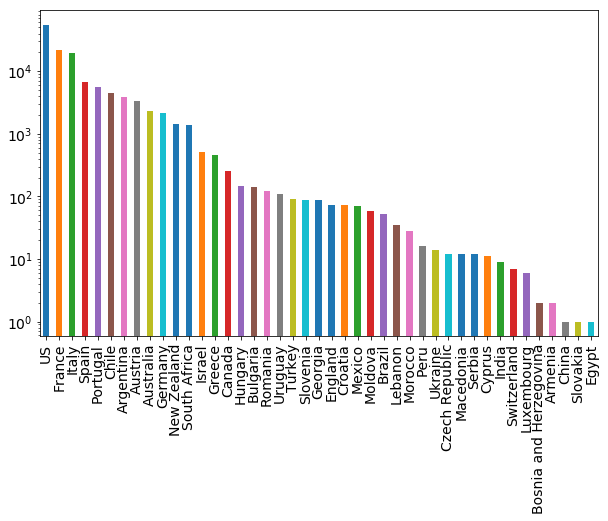

In [5]:
countries = pd.read_csv(datafile, usecols=[1])
print(countries.country.unique(), countries.nunique())
pd.value_counts(countries['country']).plot.bar(figsize=(10,6), logy=True)
count_nan = len(countries) - countries.count()
print('number of nans = {}'.format(count_nan))

In [6]:
# Designation

col_desig =pd.read_csv(datafile, usecols=[3])
print(col_desig.nunique())

designation    37979
dtype: int64


### Distribution of points

As we see below, the reviewers attribute points out of 100, but really only
in the window from 80 to 100 points.

number of nans = points    0
dtype: int64


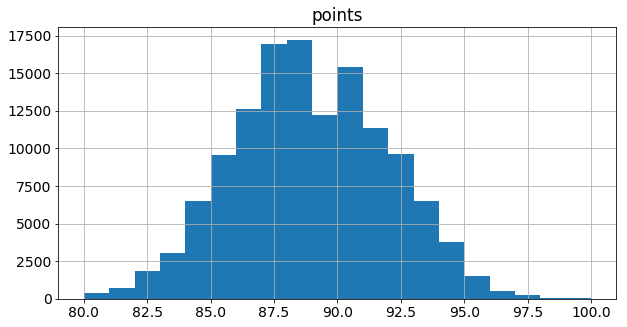

In [7]:
# Points
col_points =pd.read_csv(datafile, usecols=[4])
col_points.hist(bins=20)

count_nan = len(col_points) - col_points.count()
print('number of nans = {}'.format(count_nan))

### Prices

Prices vary wildly, with most bottles under \$100,
but a few costing over \$3000.
I expect that this is the feature that will the most strongly
correlate with the points and be most useful in prediction.
In the end, I decided to use a log scale to renormalize the 
prices. Interestingly, this gives a nice bell shape
for the distribution, with a most-likely price of about 
\$$10^{1.4}=25$.

number of nans = price    8996
dtype: int64


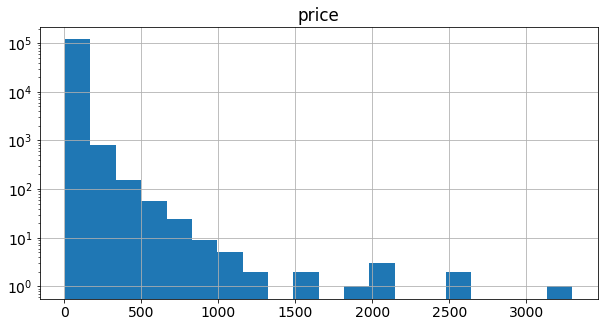

In [8]:
# Price
col_price =pd.read_csv(datafile, usecols=[5])
col_price.hist(bins=20, log=True)

count_nan = len(col_price) - col_price.count()
print('number of nans = {}'.format(count_nan))

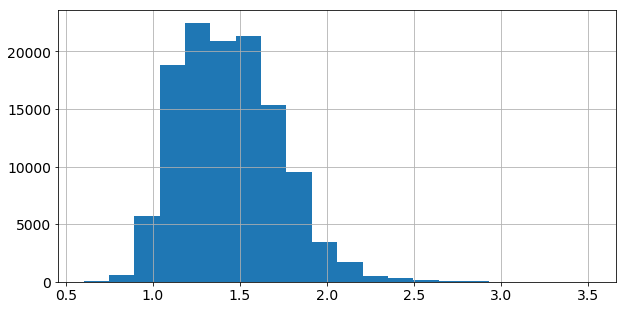

In [9]:
# Log of price histogram
col_price['price'].apply(np.log10).hist(bins=20)

### Tasters

Here as well as for the countries, 
the distribution is uneven we observe that a few tasters have done
most of the reviews.

taster_name    19
dtype: int64


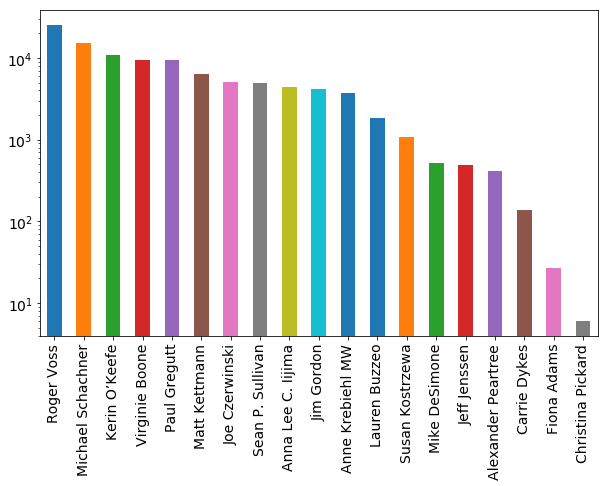

In [10]:
# Taster name


col_taster =pd.read_csv(datafile, usecols=[9])
print(col_taster.nunique())
pd.value_counts(col_taster['taster_name']).plot.bar(figsize=(10,6), logy=True)

In [11]:
# Varieties

col_vars =pd.read_csv(datafile, usecols=[12])
print(col_vars.nunique())

variety    707
dtype: int64


In [12]:
# Wineries

col_wineries =pd.read_csv(datafile, usecols=[13])
print(col_wineries.nunique())


winery    16757
dtype: int64


In [13]:
# Provinces

col_prov = pd.read_csv(datafile, usecols=[6])
print(col_prov.nunique())

count_nan = len(col_prov) - col_prov.count()
print('number of nans = {}'.format(count_nan))

province    425
dtype: int64
number of nans = province    63
dtype: int64


In [14]:
# Region 1

col_reg1 = pd.read_csv(datafile, usecols=[7])
print(col_reg1.nunique())

count_nan = len(col_reg1) - col_reg1.count()
print('number of nans = {}'.format(count_nan))

region_1    1229
dtype: int64
number of nans = region_1    21247
dtype: int64


In [15]:
# Region 2

col_reg2 = pd.read_csv(datafile, usecols=[8])
print(col_reg2.nunique())

count_nan = len(col_reg2) - col_reg2.count()
print('number of nans = {}'.format(count_nan))

# This is probably useless

region_2    17
dtype: int64
number of nans = region_2    79460
dtype: int64


## Correlation between price and points

As expected, we see a strong positive correlation between the price
of the wine and the number of points it got.
Is it a tribute to the objectivity of the price of wine, 
the better the more expensive,
or that the reviewers are swayed by the price of a costly drink?
Impossible here to tell unfortunately. It is certainly a bit of both.

Text(0,0.5,'points')

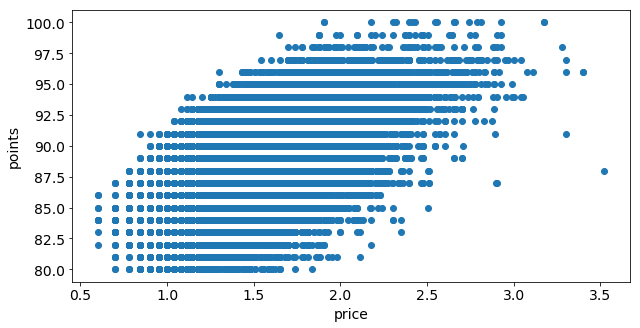

In [16]:
price_points = pd.read_csv(datafile, usecols=[4,5])
price_points['price'] = price_points['price'].apply(np.log10)

plt.scatter(price_points['price'], price_points['points'])
plt.xlabel('price')
plt.ylabel('points')


### How much data is missing

A few of the features miss quite a bit of time. 
In the end we decided to drop the "region 2" and "designation" features, 
as they are missing
in most data points, and anyway doe not seem to be that informative in general.


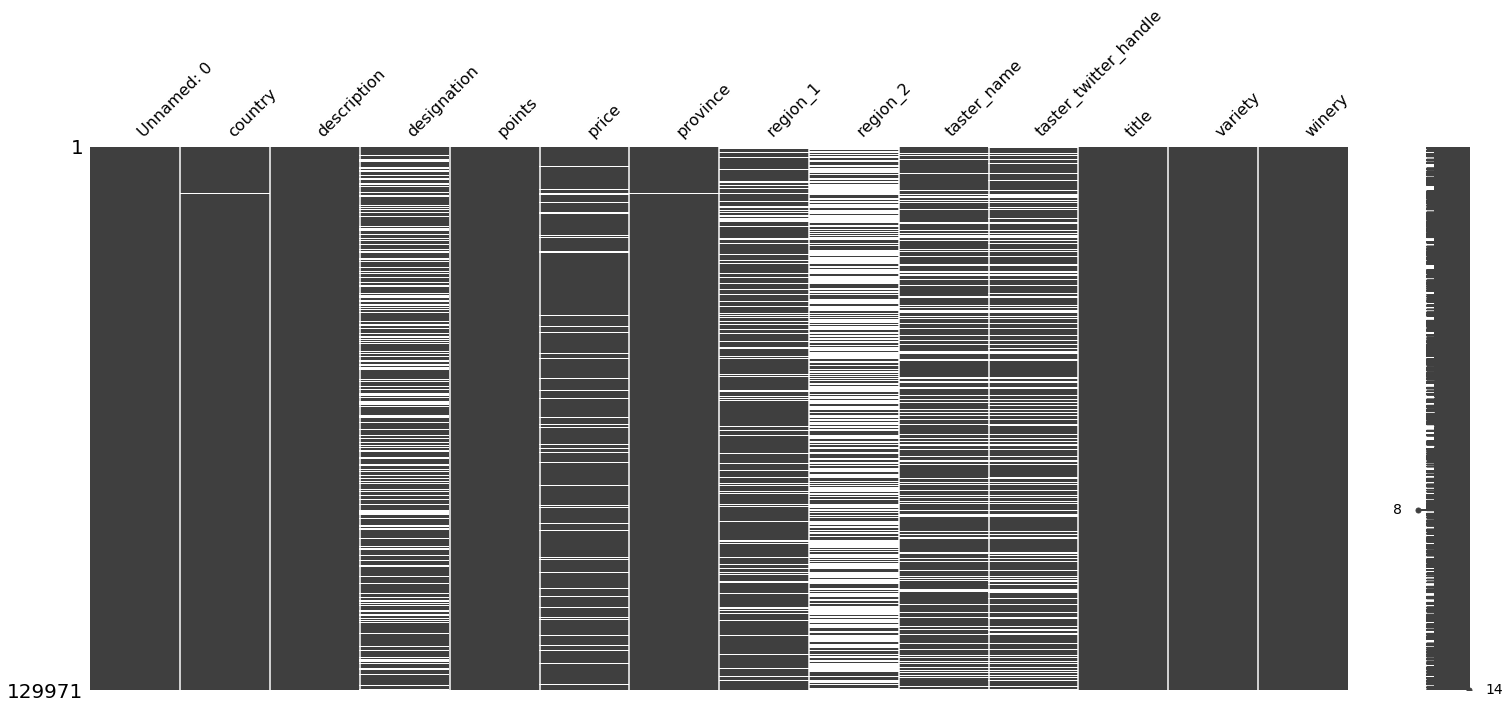

In [4]:
fulldata = pd.read_csv(datafile)
msno.matrix(fulldata)

## How much can we guess the rating from objective wine parameters

### First thing to do is to separate a chunk for testing

I tried to be very careful about information leakage by splitting
the data in a training and testing set as a first step.
Then we do some treatment of the training data, which we format
as functions, so that exactly the same treatment can be done
for the testing data.

The main problem is how to treat all the features which are strings. 
The different origin and types of the wine represent very diverse categories.
A one-hot encoding would be very impractical, as certain features
can be thousands of different categories. 
I chose to use the hashing encoding. 
This will remove a bit of information, but make sure
that the data does not become unwieldy.

As a first step, the choice is to try to guess the number of points
from all other characteristics. I chose 
to encode the grade as different categories (bad, average, good).
I made sure the distribution amongst those categories is more or less even
(with about a third of the reviews falling in each categories), such that 
it is not possible to get a good accuracy score by just betting
on the most likely categories. 

It might also be interesting to use the price as a target, 
to see if we can guess how much a wine costs by how well it is appreciated
by the reviewers.

In [5]:
from sklearn.model_selection import train_test_split

fulldata_train, fulldata_test = train_test_split(fulldata, test_size=0.1,
                                                random_state=18)

In [6]:
# As a first approach, we just drop data with missing samples
# We remove two columns with much missing values

def treat_data(dat):
    # make a function so that we can do the same procedure to the
    # test data later
    newdat = dat.drop(columns=['region_2','designation'])
    newdat = newdat.dropna()
    return newdat
    
fulldata_nona = treat_data(fulldata_train)
len(fulldata_nona)

66928

In [1]:
# Preparing data: separated in features (X) and label (y)

def make_xy(dat):
    # forget description for now
    X = dat.drop(
        columns=['description', 'title', 'taster_twitter_handle','points']) 
    # Price on log scale for nicer numbers
    X['price'] = X['price'].apply(np.log10)
    y = dat['points']
    return X, y

X_data,  y_data = make_xy(fulldata_nona)

NameError: name 'fulldata_nona' is not defined

In [8]:
# First approach: use hashing on categorical features

hashing = ce.HashingEncoder()
#Hashing function is "trained" on training data only
# to treat test data in the same way
hashing.fit(X_data, y_data)

HashingEncoder(cols=['country', 'province', 'region_1', 'taster_name', 'variety', 'winery'],
        drop_invariant=False, hash_method='md5', n_components=8,
        return_df=True, verbose=0)

In [9]:
def hashing_features(X):
    newX = hashing.transform(X)
    return newX

X_data_hashed = hashing_features(X_data)

In [10]:
# rescale target
# Choose to get 5 labels, in order to train classifier

scaling = lambda p: int((p-80)/4.)

y_data_scaled = y_data.apply(scaling)


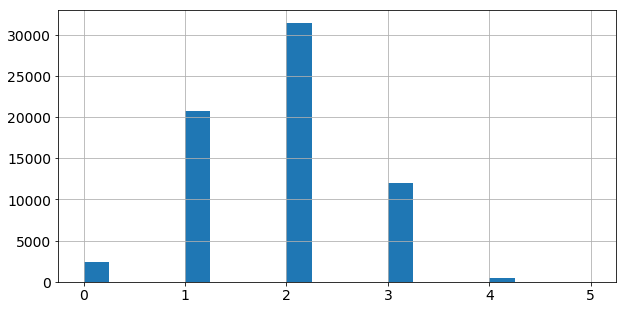

In [11]:
# Get grade from zero to five
# bad, ok, good, excellent, OOTW (out of this world)

y_data_scaled.hist(bins=20)

87 90


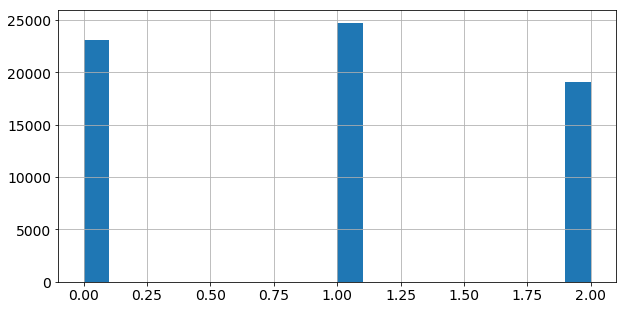

In [12]:
# Alternatively, split scores into three equivalent bins: bad, average, good

length_data = len(y_data_scaled)
split1 = y_data.sort_values().values[length_data//3]
split2 = y_data.sort_values().values[-length_data//3]

print(split1, split2)

def splitting_func(points):
    # defined for training data only
    # testing data will be scaled the same
    if points <= split1:
        return 0
    elif points <= split2:
        return 1
    else:
        return 2

def rescale_points(y):
    newy = y.apply(splitting_func)
    return newy
    
y_data_binned = rescale_points(y_data)

y_data_binned.hist(bins=20)

## Fitting the data with a random forest

Since there are many features of different kinds, 
tree classifiers and random forests seem like the best option here.
We set up a random forest classifier (with a search grid in order to optimize parameters)
and use it always on different subsets of the data,
so that the model is always of the same kind and
we are just comparing the data.

We find that by fitting our original data, we
guess the right points category 58% of the time.
As we will see below, that is much better than random guessing.


In [13]:
# Prepare testing data in the same way

X_train, y_train = X_data_hashed, y_data_binned

X_test_init, y_test_init = make_xy(treat_data(fulldata_test))
X_test = hashing_features(X_test_init)
y_test = rescale_points(y_test_init)

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [44]:
# Testing classification problem with random forests

param_grid = {
    'n_estimators': [100],
    'max_depth': [3,5,10]
}

gs = GridSearchCV(RandomForestClassifier(), param_grid, cv=10, 
                  return_train_score=True, verbose=2, n_jobs=6)

In [23]:
gs.fit(X_train, y_train)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] max_depth=3, n_estimators=100 ...................................
[CV] max_depth=3, n_estimators=100 ...................................
[CV] max_depth=3, n_estimators=100 ...................................
[CV] max_depth=3, n_estimators=100 ...................................
[CV] max_depth=3, n_estimators=100 ...................................
[CV] max_depth=3, n_estimators=100 ...................................
[CV] .................... max_depth=3, n_estimators=100, total=   6.4s
[CV] max_depth=3, n_estimators=100 ...................................
[CV] .................... max_depth=3, n_estimators=100, total=   6.5s
[CV] .................... max_depth=3, n_estimators=100, total=   6.4s
[CV] .................... max_depth=3, n_estimators=100, total=   6.4s
[CV] max_depth=3, n_estimators=100 ...................................
[CV] max_depth=3, n_estimators=100 ...................................
[CV] ...........

[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:   55.9s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=6,
       param_grid={'n_estimators': [100], 'max_depth': [3, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=2)

In [24]:
print(gs.best_estimator_.score(X_train, y_train), 
      gs.best_estimator_.score(X_test, y_test))

0.610297633277552 0.5795763172189028


### Baseline for estimating the score

As mentioned above, the target labels were split evenly so that 
there is a 1/3 chance to guess the right category purely by accident.
We check this with the dummy classifiers from sklearn, which
cannot get a score above 36% by uninformed guess.

This will provide the baseline for the scoring. If 
we can get a score larger than this, then this proves
that we can learn something from the data.
The higher the score, the more information
was contained in the data.

In [25]:
# Make a baseline for guesses

from sklearn.dummy import DummyClassifier

strategies = ['stratified', 'most_frequent', 'prior', 'uniform']#, 'constant']

for stra in strategies:
    dummy1 = DummyClassifier(strategy = stra)
    dummy1.fit(X_train, y_train)
    print('strategy {} gives a score of {}'.format(stra,dummy1.score(X_test, y_test)))

strategy stratified gives a score of 0.3329712112982075
strategy most_frequent gives a score of 0.36298207495926127
strategy prior gives a score of 0.36298207495926127
strategy uniform gives a score of 0.33460076045627374


### Is there more information in the wine origin or the price?

As expected, by just using the price, 
we have already quite a good guess,
with an accuracy of 56%.
Indeed, the price seems the most useful feature that correlates
most with the points.

In [26]:
# Drop all but price


gs.fit(X_train[['price']], y_train)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] max_depth=3, n_estimators=100 ...................................
[CV] max_depth=3, n_estimators=100 ...................................
[CV] max_depth=3, n_estimators=100 ...................................
[CV] max_depth=3, n_estimators=100 ...................................
[CV] max_depth=3, n_estimators=100 ...................................
[CV] max_depth=3, n_estimators=100 ...................................
[CV] .................... max_depth=3, n_estimators=100, total=   4.3s
[CV] max_depth=3, n_estimators=100 ...................................
[CV] .................... max_depth=3, n_estimators=100, total=   4.3s
[CV] max_depth=3, n_estimators=100 ...................................
[CV] .................... max_depth=3, n_estimators=100, total=   4.4s
[CV] max_depth=3, n_estimators=100 ...................................
[CV] .................... max_depth=3, n_estimators=100, total=   4.4s
[CV] max_depth=3

[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:   34.2s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=6,
       param_grid={'n_estimators': [100], 'max_depth': [3, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=2)

In [29]:
print(gs.best_estimator_.score(X_train[['price']], y_train), 
      gs.best_estimator_.score(X_test[['price']], y_test))

0.5595117140808032 0.561108093427485


In [30]:
# Drop the price


gs.fit(X_train.drop(columns='price'), y_train)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] max_depth=3, n_estimators=100 ...................................
[CV] max_depth=3, n_estimators=100 ...................................
[CV] max_depth=3, n_estimators=100 ...................................
[CV] max_depth=3, n_estimators=100 ...................................
[CV] max_depth=3, n_estimators=100 ...................................
[CV] max_depth=3, n_estimators=100 ...................................
[CV] .................... max_depth=3, n_estimators=100, total=   5.9s
[CV] max_depth=3, n_estimators=100 ...................................
[CV] .................... max_depth=3, n_estimators=100, total=   5.9s
[CV] max_depth=3, n_estimators=100 ...................................
[CV] .................... max_depth=3, n_estimators=100, total=   5.9s
[CV] .................... max_depth=3, n_estimators=100, total=   5.9s
[CV] max_depth=3, n_estimators=100 ...................................
[CV] max_depth=3

[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:   52.7s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=6,
       param_grid={'n_estimators': [100], 'max_depth': [3, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=2)

In [31]:
print(gs.best_estimator_.score(X_train.drop(columns='price'), y_train), 
      gs.best_estimator_.score(X_test.drop(columns='price'), y_test))

0.4994322256753526 0.455458989679522


It is interesting that just by knowing the location and type of wine (and identity of the reviewer), 
we can still do a good guess whether the wine is good or not. 
This is most likely due to the fact that the list of wine is not random. The wines are chosen to be reviewed. If the reviewer chooses an exotic wine coming from a far away place, that is hard to obtain, they will most likely choose one with a good reputation rather than the local cheap wine. 


## Let's try now to extract information from the description of the wine

The description is a long string of words of different lengths,
for each wine. 
We need to treat the data in some way,
before it can be comprehended by a random forest.

### feature from number of words

The easiest thing to do with a long text to turn it into a number is simply to count the words. 
The assumption is that the length of the review will have something to do with
how much the reviewer enjoyed the wine.

As expected, better wines receive longer reviews. 
Surprisingly, the very best wines don't have the
absolute longest reviews, but rather there is a category between 92 and 98 points
that can get the longest reviews.

As a further check, it woud be interesting to study 
the correlation of the descripiton length with the wine reviewers.
Certainly some wine reviewers give longer reviews than others

Suprisingly, there seems to be much less of a clear correlation
between the description length and the price.
In that case, it would seem that price and description length
are good complementary informations to guess the number of points.

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,descr_length
10684,31
78035,40
72938,41
90265,36
75304,27


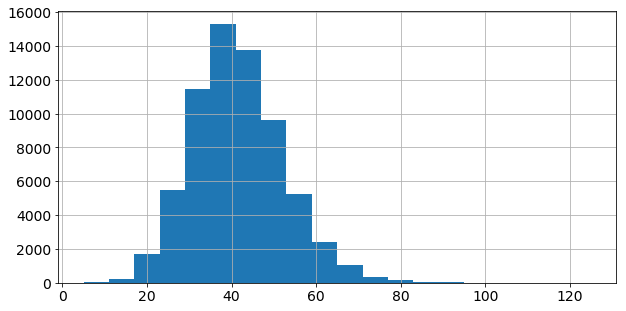

In [38]:

count_words = lambda d: len(d.split())

def get_descr_length(dat):
    descr = dat[['description']]
    descr['descr_length'] = descr['description'].apply(count_words)
    return descr.drop(columns='description')

descr_length = get_descr_length(fulldata_nona)

descr_length['descr_length'].hist(bins=20)
descr_length.head()

In [46]:
a = pd.DataFrame({"A":[1,2,3]})
a['A'].map(lambda x: x*2)
a

,A
0,1
1,2
2,3


Text(0,0.5,'points')

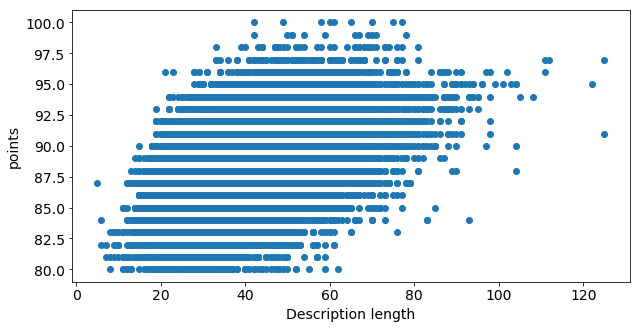

In [47]:
# Correlation between points of wine and number of words

plt.scatter(descr_length['descr_length'], fulldata_nona['points'])
plt.xlabel('Description length')
plt.ylabel('points')

Text(0,0.5,'price')

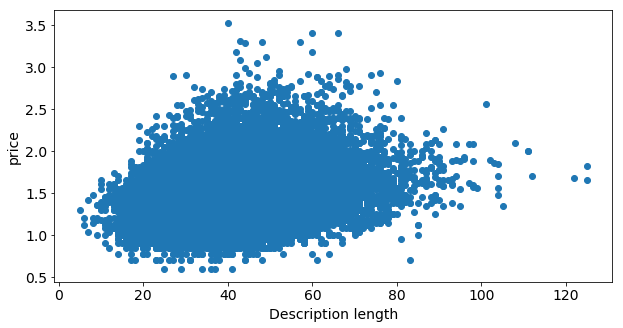

In [49]:
plt.scatter(descr_length['descr_length'], fulldata_nona['price'].apply(np.log10))
plt.xlabel('Description length')
plt.ylabel('price')

In [39]:
# Adding the new feature to the data


X_train_2 = pd.concat([X_train, descr_length], axis=1)

descr_le_test = get_descr_length(treat_data(fulldata_test))

X_test_2 = pd.concat([X_test, descr_le_test], axis=1)

X_test_2.head()
#descr_le_test.head()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,Unnamed: 0,price,descr_length
30684,0,0,1,2,2,0,0,1,30684,1.041393,41
27343,2,1,1,0,0,0,1,1,27343,1.653213,65
35514,0,1,0,2,0,2,0,1,35514,0.903090,27
89077,0,0,1,2,1,0,2,0,89077,1.397940,53
126252,0,0,3,0,0,0,2,1,126252,1.681241,65


In [55]:
# Fit with description length


gs.fit(X_train_2, y_train)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] max_depth=3, n_estimators=100 ...................................
[CV] max_depth=3, n_estimators=100 ...................................
[CV] max_depth=3, n_estimators=100 ...................................
[CV] max_depth=3, n_estimators=100 ...................................
[CV] max_depth=3, n_estimators=100 ...................................
[CV] max_depth=3, n_estimators=100 ...................................
[CV] .................... max_depth=3, n_estimators=100, total=   6.3s
[CV] max_depth=3, n_estimators=100 ...................................
[CV] .................... max_depth=3, n_estimators=100, total=   6.3s
[CV] .................... max_depth=3, n_estimators=100, total=   6.3s
[CV] max_depth=3, n_estimators=100 ...................................
[CV] max_depth=3, n_estimators=100 ...................................
[CV] .................... max_depth=3, n_estimators=100, total=   6.4s
[CV] ...........

[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:   56.2s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=6,
       param_grid={'n_estimators': [100], 'max_depth': [3, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=2)

In [69]:
print(gs.best_estimator_.score(X_train_2, y_train), 
      gs.best_estimator_.score(X_test_2, y_test))

0.6531197704996414 0.6208582292232482


Indeed we increase the score significantly by adding the description length 
as a new feature.

In [70]:
# What if we only keep this new feature


gs.fit(descr_length, y_train)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] max_depth=3, n_estimators=100 ...................................
[CV] max_depth=3, n_estimators=100 ...................................
[CV] max_depth=3, n_estimators=100 ...................................
[CV] max_depth=3, n_estimators=100 ...................................
[CV] max_depth=3, n_estimators=100 ...................................
[CV] max_depth=3, n_estimators=100 ...................................
[CV] .................... max_depth=3, n_estimators=100, total=   4.3s
[CV] .................... max_depth=3, n_estimators=100, total=   4.3s
[CV] max_depth=3, n_estimators=100 ...................................
[CV] max_depth=3, n_estimators=100 ...................................
[CV] .................... max_depth=3, n_estimators=100, total=   4.3s
[CV] max_depth=3, n_estimators=100 ...................................
[CV] .................... max_depth=3, n_estimators=100, total=   4.3s
[CV] ...........

[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:   30.2s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=6,
       param_grid={'n_estimators': [100], 'max_depth': [3, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=2)

In [72]:
print(gs.best_estimator_.score(descr_length, y_train), 
      gs.best_estimator_.score(descr_le_test, y_test))

0.49859550561797755 0.5058392178164042


This is almost as good as the price in order to predict the score of the wine.

### Find the n most common words in description

As a further treatment of the description, I had the idea of
checking the 100 most common words used in the description in the
whole data.
Then for each wine review, it is possible to create a feature
whether a given word is present or not in the review.
The idea is that certain words might "signal" a good or a bad wine.
I would like to check whether certain words tend to increase
the wine score or decrease it.

Unfortunately, due to contraints in time, I could not finish this treatment.

In [16]:
import string, re
descr = fulldata_nona[['description']]

# remove punctuation
regex = re.compile('[%s]' % re.escape(string.punctuation))

# Count 100 most common words
commonwords = pd.Series(regex.sub('',(' '.join(descr.description).lower()))
                                  .split()).value_counts()[:100]

In [26]:

(commonwords.index)

100

In [36]:
# create features for if it includes a certain word

def includes_word(w):
    def inclues_w(desc):
        if w in desc:
            return 1
        else:
            return 0
    return includes_w

def add_includes_words(dat):
    descr = dat[['description']]
    for word in commonwords.index:
        descr['incl_{}'.format(word)] = descr['description'].apply(count_word(word)).head()
    return descr.drop(columns='description')

descr_incl = add_includes_words(fulldata_nona)
descr_incl.head()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,incl_and,incl_the,incl_a,incl_of,incl_this,incl_with,incl_is,incl_wine,incl_in,incl_flavors,...,incl_peach,incl_hint,incl_lead,incl_be,incl_all,incl_note,incl_made,incl_structure,incl_into,incl_along
10684,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78035,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
72938,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
90265,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
75304,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [42]:
# Adding the new feature to the data


X_train_3 = pd.concat([X_train_2, descr_incl], axis=1)

descr_incl_test = add_includes_words(treat_data(fulldata_test))

X_test_3 = pd.concat([X_test_2, descr_incl_test], axis=1)

X_test_3.head()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,Unnamed: 0,price,...,incl_peach,incl_hint,incl_lead,incl_be,incl_all,incl_note,incl_made,incl_structure,incl_into,incl_along
30684,0,0,1,2,2,0,0,1,30684,1.041393,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
27343,2,1,1,0,0,0,1,1,27343,1.653213,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
35514,0,1,0,2,0,2,0,1,35514,0.903090,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
89077,0,0,1,2,1,0,2,0,89077,1.397940,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
126252,0,0,3,0,0,0,2,1,126252,1.681241,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [47]:
# Fit with includes words


gs.fit(X_train_3, y_train)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] max_depth=3, n_estimators=100 ...................................
[CV] max_depth=3, n_estimators=100 ...................................
[CV] max_depth=3, n_estimators=100 ...................................
[CV] max_depth=3, n_estimators=100 ...................................
[CV] max_depth=3, n_estimators=100 ...................................
[CV] max_depth=3, n_estimators=100 ...................................


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x1018e8c00, file "/usr...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/usr/local/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/usr/local/lib/python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x1018e8c00, file "/usr...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/usr/local/lib/python3.6/site-packages/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/usr/local/lib/python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/usr/local/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/usr/local/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    481         if self.poller is not None:
    482             self.poller.start()
    483         self.kernel.start()
    484         self.io_loop = ioloop.IOLoop.current()
    485         try:
--> 486             self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    487         except KeyboardInterrupt:
    488             pass
    489 
    490 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/usr/local/lib/python3.6/site-packages/tornado/platform/asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    107         except (RuntimeError, AssertionError):
    108             old_loop = None
    109         try:
    110             self._setup_logging()
    111             asyncio.set_event_loop(self.asyncio_loop)
--> 112             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Uni...EventLoop running=True closed=False debug=False>>
    113         finally:
    114             asyncio.set_event_loop(old_loop)
    115 
    116     def stop(self):

...........................................................................
/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py in run_forever(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
    417             sys.set_asyncgen_hooks(firstiter=self._asyncgen_firstiter_hook,
    418                                    finalizer=self._asyncgen_finalizer_hook)
    419         try:
    420             events._set_running_loop(self)
    421             while True:
--> 422                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_UnixS...EventLoop running=True closed=False debug=False>>
    423                 if self._stopping:
    424                     break
    425         finally:
    426             self._stopping = False

...........................................................................
/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py in _run_once(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
   1427                         logger.warning('Executing %s took %.3f seconds',
   1428                                        _format_handle(handle), dt)
   1429                 finally:
   1430                     self._current_handle = None
   1431             else:
-> 1432                 handle._run()
        handle._run = <bound method Handle._run of <Handle BaseAsyncIOLoop._handle_events(14, 1)>>
   1433         handle = None  # Needed to break cycles when an exception occurs.
   1434 
   1435     def _set_coroutine_wrapper(self, enabled):
   1436         try:

...........................................................................
/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/events.py in _run(self=<Handle BaseAsyncIOLoop._handle_events(14, 1)>)
    140             self._callback = None
    141             self._args = None
    142 
    143     def _run(self):
    144         try:
--> 145             self._callback(*self._args)
        self._callback = <bound method BaseAsyncIOLoop._handle_events of <tornado.platform.asyncio.AsyncIOMainLoop object>>
        self._args = (14, 1)
    146         except Exception as exc:
    147             cb = _format_callback_source(self._callback, self._args)
    148             msg = 'Exception in callback {}'.format(cb)
    149             context = {

...........................................................................
/usr/local/lib/python3.6/site-packages/tornado/platform/asyncio.py in _handle_events(self=<tornado.platform.asyncio.AsyncIOMainLoop object>, fd=14, events=1)
     97             self.writers.remove(fd)
     98         del self.handlers[fd]
     99 
    100     def _handle_events(self, fd, events):
    101         fileobj, handler_func = self.handlers[fd]
--> 102         handler_func(fileobj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fileobj = <zmq.sugar.socket.Socket object>
        events = 1
    103 
    104     def start(self):
    105         try:
    106             old_loop = asyncio.get_event_loop()

...........................................................................
/usr/local/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
/usr/local/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': '# Fit with includes words\n\n\ngs.fit(X_train_3, y_train)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 5, 30, 13, 34, 18, 960912, tzinfo=tzutc()), 'msg_id': '46a9ecfa4ded42468eed9fc4b95baba0', 'msg_type': 'execute_request', 'session': '1c03199ddf364bde87dced114fb67760', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '46a9ecfa4ded42468eed9fc4b95baba0', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'1c03199ddf364bde87dced114fb67760']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': '# Fit with includes words\n\n\ngs.fit(X_train_3, y_train)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 5, 30, 13, 34, 18, 960912, tzinfo=tzutc()), 'msg_id': '46a9ecfa4ded42468eed9fc4b95baba0', 'msg_type': 'execute_request', 'session': '1c03199ddf364bde87dced114fb67760', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '46a9ecfa4ded42468eed9fc4b95baba0', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'1c03199ddf364bde87dced114fb67760'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': '# Fit with includes words\n\n\ngs.fit(X_train_3, y_train)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 5, 30, 13, 34, 18, 960912, tzinfo=tzutc()), 'msg_id': '46a9ecfa4ded42468eed9fc4b95baba0', 'msg_type': 'execute_request', 'session': '1c03199ddf364bde87dced114fb67760', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '46a9ecfa4ded42468eed9fc4b95baba0', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/usr/local/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='# Fit with includes words\n\n\ngs.fit(X_train_3, y_train)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = '# Fit with includes words\n\n\ngs.fit(X_train_3, y_train)'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/usr/local/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('# Fit with includes words\n\n\ngs.fit(X_train_3, y_train)',), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('# Fit with includes words\n\n\ngs.fit(X_train_3, y_train)',)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='# Fit with includes words\n\n\ngs.fit(X_train_3, y_train)', store_history=True, silent=False, shell_futures=True)
   2657         -------
   2658         result : :class:`ExecutionResult`
   2659         """
   2660         try:
   2661             result = self._run_cell(
-> 2662                 raw_cell, store_history, silent, shell_futures)
        raw_cell = '# Fit with includes words\n\n\ngs.fit(X_train_3, y_train)'
        store_history = True
        silent = False
        shell_futures = True
   2663         finally:
   2664             self.events.trigger('post_execute')
   2665             if not silent:
   2666                 self.events.trigger('post_run_cell', result)

...........................................................................
/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py in _run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='# Fit with includes words\n\n\ngs.fit(X_train_3, y_train)', store_history=True, silent=False, shell_futures=True)
   2780                 self.displayhook.exec_result = result
   2781 
   2782                 # Execute the user code
   2783                 interactivity = 'none' if silent else self.ast_node_interactivity
   2784                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2785                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2786                 
   2787                 self.last_execution_succeeded = not has_raised
   2788                 self.last_execution_result = result
   2789 

...........................................................................
/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Expr object>], cell_name='<ipython-input-47-77a7dca036a0>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 120348c18, execution_...rue silent=False shell_futures=True> result=None>)
   2904                     return True
   2905 
   2906             for i, node in enumerate(to_run_interactive):
   2907                 mod = ast.Interactive([node])
   2908                 code = compiler(mod, cell_name, "single")
-> 2909                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x10cfe14b0, file "<ipython-input-47-77a7dca036a0>", line 4>
        result = <ExecutionResult object at 120348c18, execution_...rue silent=False shell_futures=True> result=None>
   2910                     return True
   2911 
   2912             # Flush softspace
   2913             if softspace(sys.stdout, 0):

...........................................................................
/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x10cfe14b0, file "<ipython-input-47-77a7dca036a0>", line 4>, result=<ExecutionResult object at 120348c18, execution_...rue silent=False shell_futures=True> result=None>)
   2958         outflag = True  # happens in more places, so it's easier as default
   2959         try:
   2960             try:
   2961                 self.hooks.pre_run_code_hook()
   2962                 #rprint('Running code', repr(code_obj)) # dbg
-> 2963                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x10cfe14b0, file "<ipython-input-47-77a7dca036a0>", line 4>
        self.user_global_ns = {'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', '# Imports\n\nimport pandas as pd\nimport numpy as n...ort category_encoders as ce\nimport sklearn as skl', '# plot parameters\n\nplt.rcParams["figure.figsize"] = (10, 5)\nplt.rcParams["font.size"] = 14', "# Open data\n\ndatafile = 'data/wine-reviews/winem...csv'\ndata_small = pd.read_csv(datafile, nrows=10)", 'fulldata = pd.read_csv(datafile)\nmsno.matrix(fulldata)', 'from sklearn.model_selection import train_test_s...                                 random_state=18)', '# As a first approach, we just drop data with mi...a = treat_data(fulldata_train)\nlen(fulldata_nona)', '# Preparing data\n\ndef make_xy(dat):\n    # forget...rn X, y\n\nX_data,  y_data = make_xy(fulldata_nona)', '# First approach: use hashing on categorical fea... data in the same way\nhashing.fit(X_data, y_data)', 'def hashing_features(X):\n    newX = hashing.tran...rn newX\n\nX_data_hashed = hashing_features(X_data)', '# rescale target\n# Choose to get 5 labels, in or...(p-80)/4.)\n\ny_data_scaled = y_data.apply(scaling)', '# Get grade from zero to five\n# bad, ok, good, e... (out of this world)\n\ny_data_scaled.hist(bins=20)', '# Alternatively, split scores into three equival...scale_points(y_data)\n\ny_data_binned.hist(bins=20)', '# Prepare testing data in the same way\n\nX_train,...X_test_init)\ny_test = rescale_points(y_test_init)', 'from sklearn.ensemble import RandomForestClassifier\nfrom sklearn.model_selection import GridSearchCV', '\ncommonwords[:20]', "import string, re\ndescr = fulldata_nona[['descri...                   .split()).value_counts()[:100]", '\ncommonwords[:20]', '\ncommonwords[:40]', "\ncommonwords['and']", ...], 'Out': {4: <matplotlib.axes._subplots.AxesSubplot object>, 6: 66928, 8: HashingEncoder(cols=['country', 'province', 'reg..._components=8,
        return_df=True, verbose=0), 11: <matplotlib.axes._subplots.AxesSubplot object>, 12: <matplotlib.axes._subplots.AxesSubplot object>, 17: and        183160
the        117475
a           ...
finish      18871
that        17500
dtype: int64, 18: and        183160
the        117475
a           ...
oak          8687
plum         8660
dtype: int64, 19: 183160, 20: 9750, 21: and          183160
the          117475
a       ...629
along          3617
Length: 100, dtype: int64, ...}, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'X_data':         Unnamed: 0    country     price         ...              Angosto  

[66928 rows x 8 columns], 'X_data_hashed':         col_0  col_1  col_2  col_3  col_4  col_5...0  
60714   1.698970  

[66928 rows x 10 columns], 'X_test':         col_0  col_1  col_2  col_3  col_4  col_5...49  
15675   1.812913  

[7364 rows x 10 columns], 'X_test_2':         col_0  col_1  col_2  col_3  col_4  col_5....812913            44  

[7364 rows x 11 columns], 'X_test_3':         col_0  col_1  col_2  col_3  col_4  col_5...     NaN         NaN  

[7364 rows x 111 columns], 'X_test_init':         Unnamed: 0    country     price         ...               Lachini  

[7364 rows x 8 columns], ...}
        self.user_ns = {'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', '# Imports\n\nimport pandas as pd\nimport numpy as n...ort category_encoders as ce\nimport sklearn as skl', '# plot parameters\n\nplt.rcParams["figure.figsize"] = (10, 5)\nplt.rcParams["font.size"] = 14', "# Open data\n\ndatafile = 'data/wine-reviews/winem...csv'\ndata_small = pd.read_csv(datafile, nrows=10)", 'fulldata = pd.read_csv(datafile)\nmsno.matrix(fulldata)', 'from sklearn.model_selection import train_test_s...                                 random_state=18)', '# As a first approach, we just drop data with mi...a = treat_data(fulldata_train)\nlen(fulldata_nona)', '# Preparing data\n\ndef make_xy(dat):\n    # forget...rn X, y\n\nX_data,  y_data = make_xy(fulldata_nona)', '# First approach: use hashing on categorical fea... data in the same way\nhashing.fit(X_data, y_data)', 'def hashing_features(X):\n    newX = hashing.tran...rn newX\n\nX_data_hashed = hashing_features(X_data)', '# rescale target\n# Choose to get 5 labels, in or...(p-80)/4.)\n\ny_data_scaled = y_data.apply(scaling)', '# Get grade from zero to five\n# bad, ok, good, e... (out of this world)\n\ny_data_scaled.hist(bins=20)', '# Alternatively, split scores into three equival...scale_points(y_data)\n\ny_data_binned.hist(bins=20)', '# Prepare testing data in the same way\n\nX_train,...X_test_init)\ny_test = rescale_points(y_test_init)', 'from sklearn.ensemble import RandomForestClassifier\nfrom sklearn.model_selection import GridSearchCV', '\ncommonwords[:20]', "import string, re\ndescr = fulldata_nona[['descri...                   .split()).value_counts()[:100]", '\ncommonwords[:20]', '\ncommonwords[:40]', "\ncommonwords['and']", ...], 'Out': {4: <matplotlib.axes._subplots.AxesSubplot object>, 6: 66928, 8: HashingEncoder(cols=['country', 'province', 'reg..._components=8,
        return_df=True, verbose=0), 11: <matplotlib.axes._subplots.AxesSubplot object>, 12: <matplotlib.axes._subplots.AxesSubplot object>, 17: and        183160
the        117475
a           ...
finish      18871
that        17500
dtype: int64, 18: and        183160
the        117475
a           ...
oak          8687
plum         8660
dtype: int64, 19: 183160, 20: 9750, 21: and          183160
the          117475
a       ...629
along          3617
Length: 100, dtype: int64, ...}, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'X_data':         Unnamed: 0    country     price         ...              Angosto  

[66928 rows x 8 columns], 'X_data_hashed':         col_0  col_1  col_2  col_3  col_4  col_5...0  
60714   1.698970  

[66928 rows x 10 columns], 'X_test':         col_0  col_1  col_2  col_3  col_4  col_5...49  
15675   1.812913  

[7364 rows x 10 columns], 'X_test_2':         col_0  col_1  col_2  col_3  col_4  col_5....812913            44  

[7364 rows x 11 columns], 'X_test_3':         col_0  col_1  col_2  col_3  col_4  col_5...     NaN         NaN  

[7364 rows x 111 columns], 'X_test_init':         Unnamed: 0    country     price         ...               Lachini  

[7364 rows x 8 columns], ...}
   2964             finally:
   2965                 # Reset our crash handler in place
   2966                 sys.excepthook = old_excepthook
   2967         except SystemExit as e:

...........................................................................
/Users/nbernier/GoogleDrive/LPQM/git/advanced-comp-2018/<ipython-input-47-77a7dca036a0> in <module>()
      1 # Fit with includes words
      2 
      3 
----> 4 gs.fit(X_train_3, y_train)

...........................................................................
/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_search.py in fit(self=GridSearchCV(cv=10, error_score='raise',
       ...train_score=True,
       scoring=None, verbose=2), X=        col_0  col_1  col_2  col_3  col_4  col_5...    NaN         NaN  

[66928 rows x 111 columns], y=10684     0
78035     1
72938     2
90265     0
...4     0
Name: points, Length: 66928, dtype: int64, groups=None, **fit_params={})
    634                                   return_train_score=self.return_train_score,
    635                                   return_n_test_samples=True,
    636                                   return_times=True, return_parameters=False,
    637                                   error_score=self.error_score)
    638           for parameters, (train, test) in product(candidate_params,
--> 639                                                    cv.split(X, y, groups)))
        cv.split = <bound method StratifiedKFold.split of Stratifie...d(n_splits=10, random_state=None, shuffle=False)>
        X =         col_0  col_1  col_2  col_3  col_4  col_5...    NaN         NaN  

[66928 rows x 111 columns]
        y = 10684     0
78035     1
72938     2
90265     0
...4     0
Name: points, Length: 66928, dtype: int64
        groups = None
    640 
    641         # if one choose to see train score, "out" will contain train score info
    642         if self.return_train_score:
    643             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
/usr/local/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=6), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=6)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Wed May 30 15:34:19 2018
PID: 1864                 Python 3.6.5: /usr/local/opt/python/bin/python3.6
...........................................................................
/usr/local/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False),         col_0  col_1  col_2  col_3  col_4  col_5...    NaN         NaN  

[66928 rows x 111 columns], 10684     0
78035     1
72938     2
90265     0
...4     0
Name: points, Length: 66928, dtype: int64, {'score': <function _passthrough_scorer>}, array([ 6581,  6587,  6588, ..., 66925, 66926, 66927]), array([   0,    1,    2, ..., 6760, 6765, 6767]), 2, {'max_depth': 3, 'n_estimators': 100}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': True})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/usr/local/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False),         col_0  col_1  col_2  col_3  col_4  col_5...    NaN         NaN  

[66928 rows x 111 columns], 10684     0
78035     1
72938     2
90265     0
...4     0
Name: points, Length: 66928, dtype: int64, {'score': <function _passthrough_scorer>}, array([ 6581,  6587,  6588, ..., 66925, 66926, 66927]), array([   0,    1,    2, ..., 6760, 6765, 6767]), 2, {'max_depth': 3, 'n_estimators': 100})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': True}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), X=        col_0  col_1  col_2  col_3  col_4  col_5...    NaN         NaN  

[66928 rows x 111 columns], y=10684     0
78035     1
72938     2
90265     0
...4     0
Name: points, Length: 66928, dtype: int64, scorer={'score': <function _passthrough_scorer>}, train=array([ 6581,  6587,  6588, ..., 66925, 66926, 66927]), test=array([   0,    1,    2, ..., 6760, 6765, 6767]), verbose=2, parameters={'max_depth': 3, 'n_estimators': 100}, fit_params={}, return_train_score=True, return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    453 
    454     try:
    455         if y_train is None:
    456             estimator.fit(X_train, **fit_params)
    457         else:
--> 458             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method BaseForest.fit of RandomForestClas...e=None, verbose=0,
            warm_start=False)>
        X_train =         col_0  col_1  col_2  col_3  col_4  col_5...    NaN         NaN  

[60234 rows x 111 columns]
        y_train = 28993     0
55769     0
94070     0
113985    0
...4     0
Name: points, Length: 60234, dtype: int64
        fit_params = {}
    459 
    460     except Exception as e:
    461         # Note fit time as time until error
    462         fit_time = time.time() - start_time

...........................................................................
/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py in fit(self=RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False), X=        col_0  col_1  col_2  col_3  col_4  col_5...    NaN         NaN  

[60234 rows x 111 columns], y=28993     0
55769     0
94070     0
113985    0
...4     0
Name: points, Length: 60234, dtype: int64, sample_weight=None)
    242         -------
    243         self : object
    244             Returns self.
    245         """
    246         # Validate or convert input data
--> 247         X = check_array(X, accept_sparse="csc", dtype=DTYPE)
        X =         col_0  col_1  col_2  col_3  col_4  col_5...    NaN         NaN  

[60234 rows x 111 columns]
    248         y = check_array(y, accept_sparse='csc', ensure_2d=False, dtype=None)
    249         if sample_weight is not None:
    250             sample_weight = check_array(sample_weight, ensure_2d=False)
    251         if issparse(X):

...........................................................................
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py in check_array(array=array([[ 0.,  1.,  0., ..., nan, nan, nan],
    ....,  0.,  2., ..., nan, nan, nan]], dtype=float32), accept_sparse='csc', dtype=<class 'numpy.float32'>, order=None, copy=False, force_all_finite=True, ensure_2d=True, allow_nd=False, ensure_min_samples=1, ensure_min_features=1, warn_on_dtype=False, estimator=None)
    448             array = array.astype(np.float64)
    449         if not allow_nd and array.ndim >= 3:
    450             raise ValueError("Found array with dim %d. %s expected <= 2."
    451                              % (array.ndim, estimator_name))
    452         if force_all_finite:
--> 453             _assert_all_finite(array)
        array = array([[ 0.,  1.,  0., ..., nan, nan, nan],
    ....,  0.,  2., ..., nan, nan, nan]], dtype=float32)
    454 
    455     shape_repr = _shape_repr(array.shape)
    456     if ensure_min_samples > 0:
    457         n_samples = _num_samples(array)

...........................................................................
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py in _assert_all_finite(X=array([[ 0.,  1.,  0., ..., nan, nan, nan],
    ....,  0.,  2., ..., nan, nan, nan]], dtype=float32))
     39     # everything is finite; fall back to O(n) space np.isfinite to prevent
     40     # false positives from overflow in sum method.
     41     if (X.dtype.char in np.typecodes['AllFloat'] and not np.isfinite(X.sum())
     42             and not np.isfinite(X).all()):
     43         raise ValueError("Input contains NaN, infinity"
---> 44                          " or a value too large for %r." % X.dtype)
        X.dtype = dtype('float32')
     45 
     46 
     47 def assert_all_finite(X):
     48     """Throw a ValueError if X contains NaN or infinity.

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').
___________________________________________________________________________

## Conclusion

The idea was two-fold. 
First, I wanted to check whether it is possible 
to guess how much a reviewer will appreciate the wine
just by looking at the objective characteristics of the wine.
I found that we can guess almost 2 out of 3 times
whether the reviewer liked the wine or not, just
by looking at its origin, its price, and the name of the reviewer.

The second objective was to try to teach the machine learning algorithm
to "understand" the written description: if it means the wine is good or bad.
The description length, without analysing it, already gives a good idea.
Good wines inspire much longer reviews than bad wines.
Unfortunately, due to time constraints, I could not go further.

### Outlook
There are several points that I would like to explore.
First, does a feature tend to increase or decrease the score.
For instance, I would like to check my assumption that an exotic wine
tends to have a better score than a domestic one.
Second, I would also like to check the characteristics of each wine taster.
Are certain wine tasters more critical? Do they write longer or shorter reviews?
Are they fond of a certain wine?

Finally, by analysing the preference of each wine taster,
one could perhaps construct a wine suggestion algorithm. 
For a given taster, due to past preferences, it would 
check whether a new wine is likely to please or not.